请对../data/AirPassengers.csv中的航空公司乘客数据进行时间序列分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = '../data_analysis_tutorial/data/AirPassengers.csv'
data = pd.read_csv(filename, index_col = 'Month')

data.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


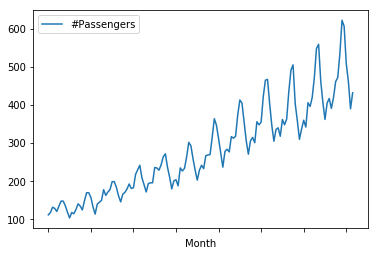

In [3]:
data.plot()
plt.show()

由上图可见，明显是非平稳序列

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


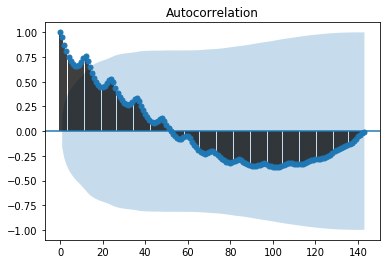

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)
plt.show()

从自相关图来看，呈现三角对称形式，不存在截尾或拖尾，属于单调序列的典型表现形式，原始数据属于不平稳序列。

In [5]:
from statsmodels.tsa.stattools import adfuller as ADF
print('原始序列的ADF检验结果为：', ADF(data['#Passengers']))

原始序列的ADF检验结果为： (0.8153688792060613, 0.9918802434376413, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)


单位根检验统计量对应的P值*远*大于0.05，说明该序列为非平稳序列。

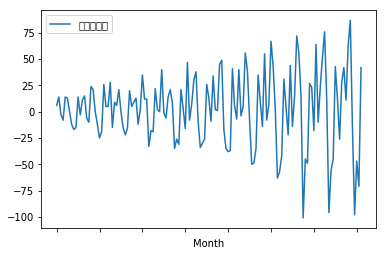

In [6]:
diff_data = data.diff().dropna()
diff_data.columns = ['乘客数差分']
diff_data.plot()
plt.show()

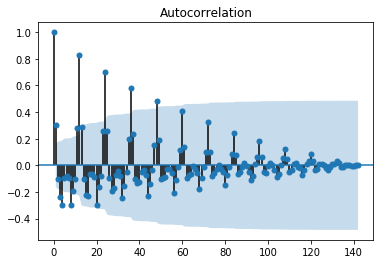

In [7]:
plot_acf(diff_data)
plt.show()

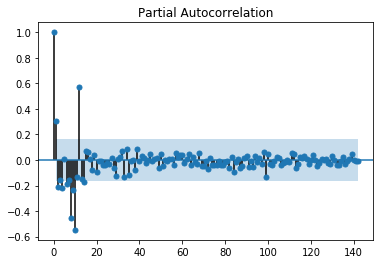

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff_data)
plt.show()

In [9]:
print('差分序列的ADF检验结果为：', ADF(diff_data['乘客数差分']))

差分序列的ADF检验结果为： (-2.829266824170008, 0.05421329028382437, 12, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.5069317854084)


In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('差分序列的白噪声检验结果为：', acorr_ljungbox(diff_data, lags=1))

差分序列的白噪声检验结果为： (array([13.39324865]), array([0.00025253]))


一阶差分后的序列的时序图在均值附件**大幅度**的波动所以还是非平稳序列

我们转换数据到另外一个空间log，这样太大的数值，影响相对较少。

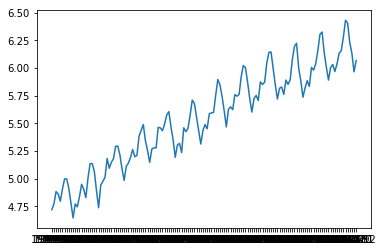

In [11]:
ps = data['#Passengers']
ps_log = np.log(ps)
plt.plot(ps_log)

平滑数据:平滑的窗口取值12，因为一年有12个月

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.


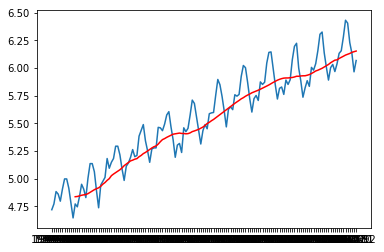

In [12]:
moving_avg = pd.rolling_mean(ps_log,12)
plt.plot(ps_log)
plt.plot(moving_avg, color='red')

In [13]:
ps_log_moving_avg_diff = ps_log - moving_avg
ps_log_moving_avg_diff.dropna(inplace=True)

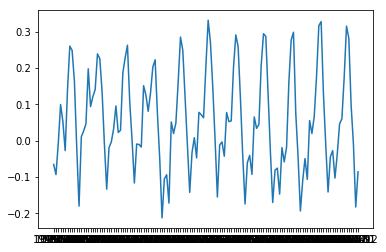

In [14]:
plt.plot(ps_log_moving_avg_diff)

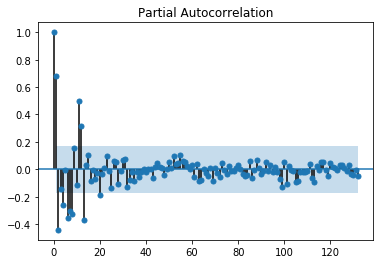

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ps_log_moving_avg_diff)
plt.show()

In [16]:
type(ps_log_moving_avg_diff)

pandas.core.series.Series

In [17]:
print('ps_log_moving_avg_diff的ADF检验结果为:', ADF(ps_log_moving_avg_diff.to_frame()['#Passengers']))

ps_log_moving_avg_diff的ADF检验结果为: (-3.1629079913008633, 0.02223463000124353, 13, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, -436.63269481747125)


In [18]:
print('ps_log_moving_avg_diff的白噪声检验结果为：', acorr_ljungbox(ps_log_moving_avg_diff.to_frame(), lags=1))

ps_log_moving_avg_diff的白噪声检验结果为： (array([63.01905601]), array([2.04716388e-15]))


p值 0.022 显著低于 0.05，所以转化后的ps_log_moving_avg_diff是平稳的非白噪声序列。

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


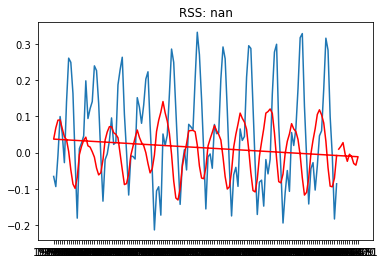

In [19]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

model = ARIMA(ps_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ps_log_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ps_log_moving_avg_diff)**2))
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'RMSE: 90.1047')

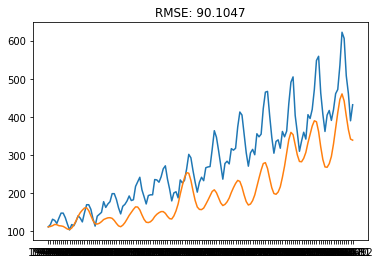

In [20]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ps_log.ix[0], index=ps_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ps)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ps)**2)/len(ps)))